## Multiple Linear Regression (End-to-End Showcase with California Housing)

This notebook demonstrates an end-to-end workflow for **multiple linear regression**
using the **California Housing** dataset, with a focus on:
- Statistical diagnostics (assumptions, residual analysis, multicollinearity via VIF & correlation heatmap)
- Model comparison (ANOVA for nested models, adjusted R-squared, AIC, BIC)
- Implementations via **scikit-learn**, **NumPy** (closed-form OLS), and **PyTorch** (gradient descent)
- Dimensionality reduction with **PCA** followed by regression
- Bonus: **Clustering** (KMeans) and **Classification** (predicting high/low price)
> Tip: Run cell-by-cell. Each section is modular to make it easier to tweak, re-run, and compare. Other module cells can be added in between if required.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# Statistics & ML
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    silhouette_score,
    classification_report,
    confusion_matrix,
)

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

# Gradient Descent
import torch
from torch import nn

In [16]:
# Plot display setup
plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid", context="notebook")
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 4)

**1. Data Load** (California Housing)

Target: `MedHouseVal` (median house value in $100,000s), renamed to `target`.

Features include median income, average rooms, average bedrooms, population, etc.

In [17]:
cal = fetch_california_housing(as_frame=True)
df = cal.frame.copy()
df.rename(columns={"MedHouseVal": "target"}, inplace=True)

# Drop capped values where target == 5
df = df[df["target"] < 5].reset_index(drop=True)

print("Shape:", df.shape)
display(df.head())
display(df.describe(include="all")) #descriptive statistics

Shape: (19648, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.9841,1.0238,322.0,2.5556,37.88,-122.23,4.526
1,8.3014,21.0,6.2381,0.9719,2401.0,2.1098,37.86,-122.22,3.585
2,7.2574,52.0,8.2881,1.0734,496.0,2.8023,37.85,-122.24,3.521
3,5.6431,52.0,5.8174,1.0731,558.0,2.5479,37.85,-122.25,3.413
4,3.8462,52.0,6.2819,1.0811,565.0,2.1815,37.85,-122.25,3.422


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,19648.0000,19648.0000,19648.0000,19648.0000,19648.0000,19648.0000,19648.0000,19648.0000,19648.0000
mean,3.6764,28.3731,5.3617,1.0966,1441.3685,3.0966,35.6519,-119.5624,1.9206
std,1.5706,12.5041,2.2933,0.4521,1144.0752,10.6392,2.1501,2.0058,0.9711
min,0.4999,1.0000,0.8462,0.3333,3.0000,0.6923,32.5400,-124.3500,0.1500
25%,2.5263,18.0000,4.4167,1.0059,796.0000,2.4466,33.9300,-121.7600,1.1647
50%,3.4490,28.0000,5.1857,1.0486,1179.0000,2.8378,34.2700,-118.5000,1.7360
75%,4.5825,37.0000,5.9711,1.0992,1746.2500,3.3060,37.7300,-117.9900,2.4790
max,15.0001,52.0000,132.5333,34.0667,35682.0000,1243.3333,41.9500,-114.3100,4.9910


**2. Quick EDA**
- Assumptions for linear regression:
1) *Linearity*: Predictors relate linearly to the target.
2) *Normality of residuals*: Residuals are approximately normal.
3) *Homoscedasticity*: Constant variance of residuals across fitted values.
4) *Independence*: Observations/residuals are independent.
- Explore distributions, pairwise relationships, and scatterplots of predictors vs target to justify linear modeling.

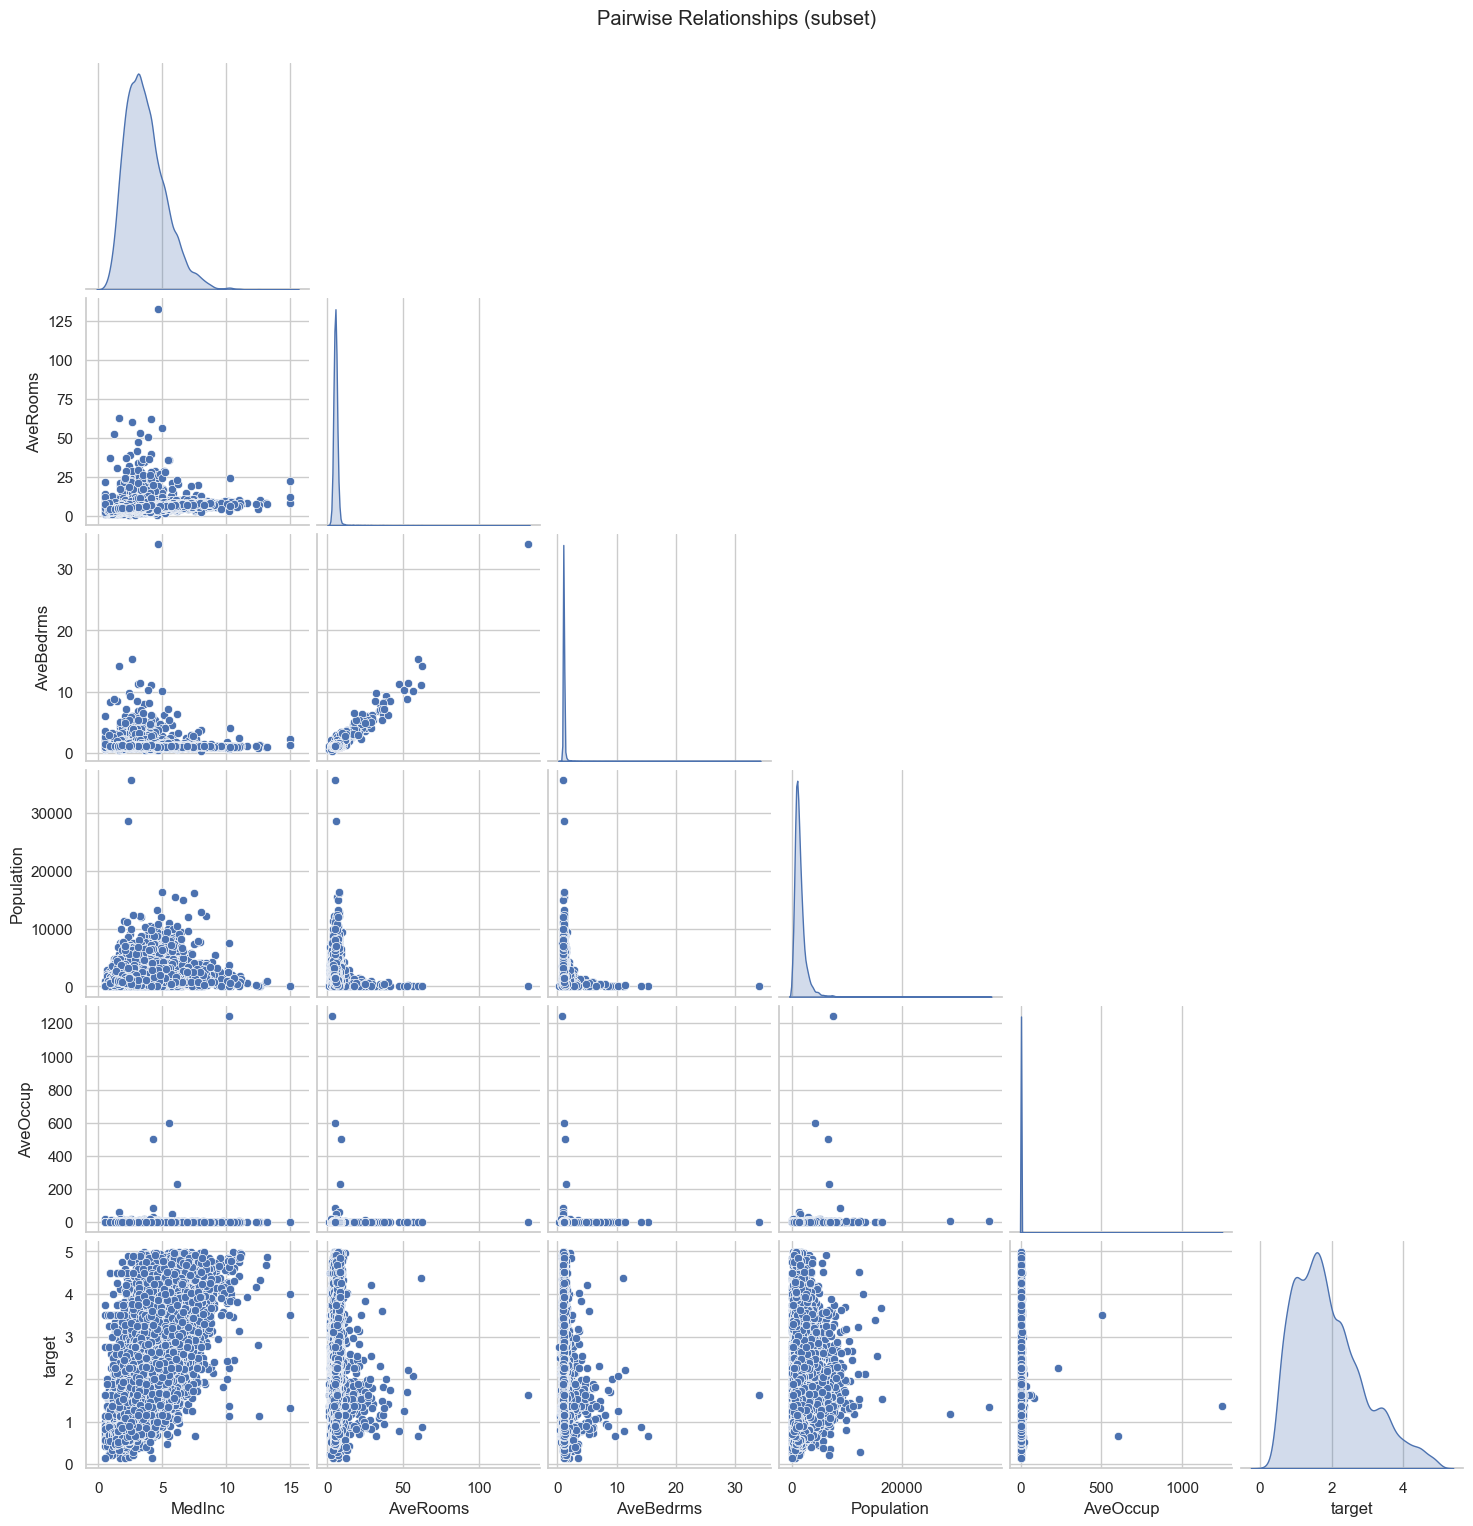

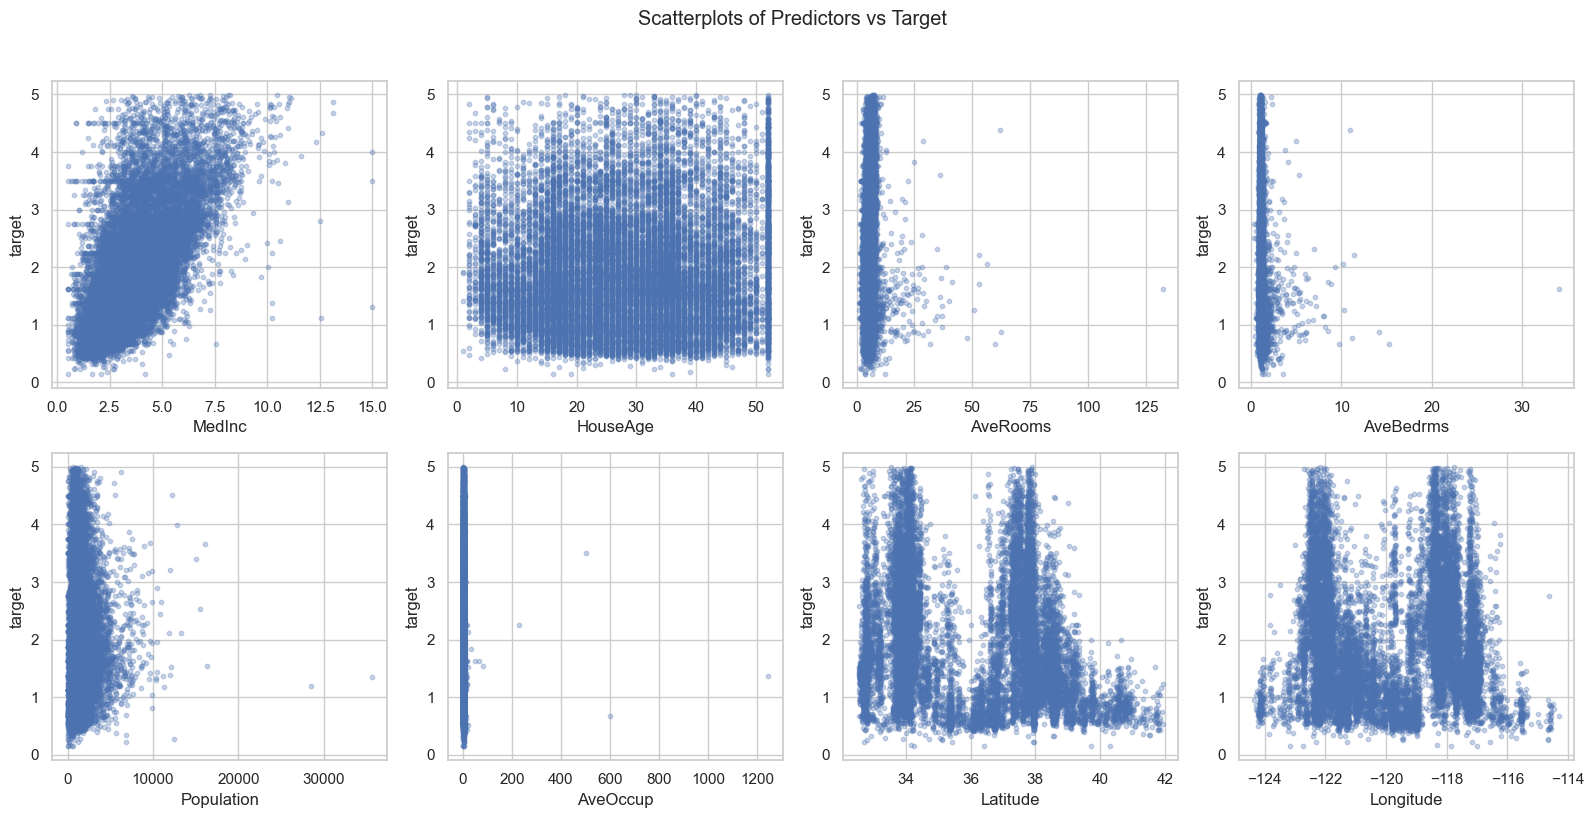

In [18]:
# Pairplot on a subset (easy to read)
subset_cols = [
    "MedInc", "AveRooms", "AveBedrms", "Population",
    "AveOccup", "target"
]
sns.pairplot(df[subset_cols], diag_kind="kde", corner=True)
plt.suptitle("Pairwise Relationships (subset)", y=1.02)
plt.show()

# Scatterplots of individual predictors vs target to eyeball linearity
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()
for i, col in enumerate(df.columns.drop("target")):
    if i >= 8:
        break
    axes[i].scatter(df[col], df["target"], alpha=0.3, s=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("target")
fig.suptitle("Scatterplots of Predictors vs Target", y=1.02)
plt.tight_layout()
plt.show()

**3) Pre-processing**
- Train/test split.
- Standardize features for gradient-based methods and PCA.

**Note:** For the sake of the showcase, I'll ignore the assumption violations.

In [19]:
X = df.drop(columns=["target"]).values
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=86
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

feature_names = df.drop(columns=["target"]).columns.tolist()
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (15718, 8) Test shape: (3930, 8)


**4. (Initial) Multiple Linear Regression**
- Implemented 3 ways:
1) **`mlr_sk`** — scikit-learn `LinearRegression` (closed-form/SVD internally).
2) **`mlr_mat`** — NumPy OLS via $(X^TX)^{-1}X^Ty$ (with intercept).
3) **`mlr_GDA`** — PyTorch gradient descent (Adam) on MSE.

- For subsequent diagnostics and comparisons **`mlr_sk`** is used.

In [20]:
def rmse_score(y_true, y_pred):
    """Compute Root Mean Squared Error (RMSE)."""
    return np.sqrt(mean_squared_error(y_true, y_pred))


# --- 4.1 sklearn LinearRegression (mlr_sk) ---
mlr_sk = LinearRegression()
mlr_sk.fit(X_train, y_train)

y_pred_train_sk = mlr_sk.predict(X_train)
y_pred_test_sk = mlr_sk.predict(X_test)

print("SKLearn MLR:")
print("  Train R^2:", r2_score(y_train, y_pred_train_sk))
print("  Train RMSE:", rmse_score(y_train, y_pred_train_sk))
print("  Test  R^2:", r2_score(y_test, y_pred_test_sk))
print("  Test  RMSE:", rmse_score(y_test, y_pred_test_sk))

coef_series = pd.Series(mlr_sk.coef_, index=feature_names, name="coef")
display(pd.DataFrame({"coef": coef_series, "abs_coef": coef_series.abs()})
        .sort_values("abs_coef", ascending=False))
print("Intercept:", mlr_sk.intercept_)


# --- 4.2 NumPy Closed-form OLS (mlr_mat) ---
X_train_1 = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_1 = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

XtX = X_train_1.T @ X_train_1
XtX_inv = np.linalg.inv(XtX)
beta = XtX_inv @ X_train_1.T @ y_train  # [intercept, coefficients...]

y_pred_train_mat = X_train_1 @ beta
y_pred_test_mat = X_test_1 @ beta

print("NumPy OLS (mlr_mat):")
print("  Train R^2:", r2_score(y_train, y_pred_train_mat))
print("  Train RMSE:", rmse_score(y_train, y_pred_train_mat))
print("  Test  R^2:", r2_score(y_test, y_pred_test_mat))
print("  Test  RMSE:", rmse_score(y_test, y_pred_test_mat))

coef_df_mat = pd.DataFrame({
    "feature": ["Intercept"] + feature_names,
    "coef": beta
})
display(coef_df_mat)


# --- 4.3 PyTorch Gradient Descent Approximation (mlr_GDA) ---
Xtr_t = torch.tensor(X_train_scaled, dtype=torch.float32)
ytr_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

torch.manual_seed(86)
model = nn.Linear(Xtr_t.shape[1], 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

for epoch in range(800):
    optimizer.zero_grad()
    yhat = model(Xtr_t)
    loss = loss_fn(yhat, ytr_t)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 200 == 0:
        pass

Xte_t = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    y_pred_train_gda = model(Xtr_t).numpy().ravel()
    y_pred_test_gda = model(Xte_t).numpy().ravel()

print("PyTorch GD (mlr_GDA):")
print("  Train R^2:", r2_score(y_train, y_pred_train_gda))
print("  Train RMSE:", rmse_score(y_train, y_pred_train_gda))
print("  Test  R^2:", r2_score(y_test, y_pred_test_gda))
print("  Test  RMSE:", rmse_score(y_test, y_pred_test_gda))

w = model.weight.detach().numpy().ravel()
b = model.bias.detach().numpy().item()
coef_df_gda = (pd.DataFrame({"feature": feature_names, "weight (std-scaled)": w})
               .sort_values("weight (std-scaled)", key=np.abs, ascending=False))
display(coef_df_gda)
print("Bias:", b)


SKLearn MLR:
  Train R^2: 0.5760804003899996
  Train RMSE: 0.6292756816197984
  Test  R^2: 0.5660424249315555
  Test  RMSE: 0.6513891561805067


,coef,abs_coef
AveBedrms,5.8251e-01,5.8251e-01
MedInc,4.3241e-01,4.3241e-01
Longitude,-3.8696e-01,3.8696e-01
Latitude,-3.7075e-01,3.7075e-01
AveRooms,-1.1058e-01,1.1058e-01
HouseAge,8.0378e-03,8.0378e-03
AveOccup,-3.5287e-03,3.5287e-03
Population,6.0936e-06,6.0936e-06


Intercept: -32.9940163170165
NumPy OLS (mlr_mat):
  Train R^2: 0.5760804003899996
  Train RMSE: 0.6292756816197984
  Test  R^2: 0.5660424249322672
  Test  RMSE: 0.6513891561799726


,feature,coef
0,Intercept,-3.2994e+01
1,MedInc,4.3241e-01
2,HouseAge,8.0378e-03
3,AveRooms,-1.1058e-01
4,AveBedrms,5.8251e-01
5,Population,6.0936e-06
6,AveOccup,-3.5287e-03
7,Latitude,-3.7075e-01
8,Longitude,-3.8696e-01


PyTorch GD (mlr_GDA):
  Train R^2: 0.5760804014442633
  Train RMSE: 0.6292756808373122
  Test  R^2: 0.5660424214971183
  Test  RMSE: 0.6513891587581264


,feature,weight (std-scaled)
6,Latitude,-0.7964
7,Longitude,-0.7770
0,MedInc,0.6773
3,AveBedrms,0.2740
2,AveRooms,-0.2575
1,HouseAge,0.1004
5,AveOccup,-0.0384
4,Population,0.0066


Bias: 1.9141967296600342


In [21]:
# %% 
# --- 4.4 Summary Comparison of Models ---

summary_df = pd.DataFrame([
    {
        "Model": "SKLearn MLR",
        "Train R^2": r2_score(y_train, y_pred_train_sk),
        "Train RMSE": rmse_score(y_train, y_pred_train_sk),
        "Test R^2": r2_score(y_test, y_pred_test_sk),
        "Test RMSE": rmse_score(y_test, y_pred_test_sk),
    },
    {
        "Model": "NumPy OLS",
        "Train R^2": r2_score(y_train, y_pred_train_mat),
        "Train RMSE": rmse_score(y_train, y_pred_train_mat),
        "Test R^2": r2_score(y_test, y_pred_test_mat),
        "Test RMSE": rmse_score(y_test, y_pred_test_mat),
    },
    {
        "Model": "PyTorch GD",
        "Train R^2": r2_score(y_train, y_pred_train_gda),
        "Train RMSE": rmse_score(y_train, y_pred_train_gda),
        "Test R^2": r2_score(y_test, y_pred_test_gda),
        "Test RMSE": rmse_score(y_test, y_pred_test_gda),
    }
])

display(summary_df)


,Model,Train R^2,Train RMSE,Test R^2,Test RMSE
0,SKLearn MLR,0.5761,0.6293,0.566,0.6514
1,NumPy OLS,0.5761,0.6293,0.566,0.6514
2,PyTorch GD,0.5761,0.6293,0.566,0.6514


**5. Residual Analysis** (for `mlr_sk`)
- Examine:
1) *Histogram* of residuals (should look roughly normal)
2) *QQ-plot* (points near the 45$^\circ$ line suggest normality)
3) *Residual vs Fitted* (to check homoscedasticity; random scatter is desired)

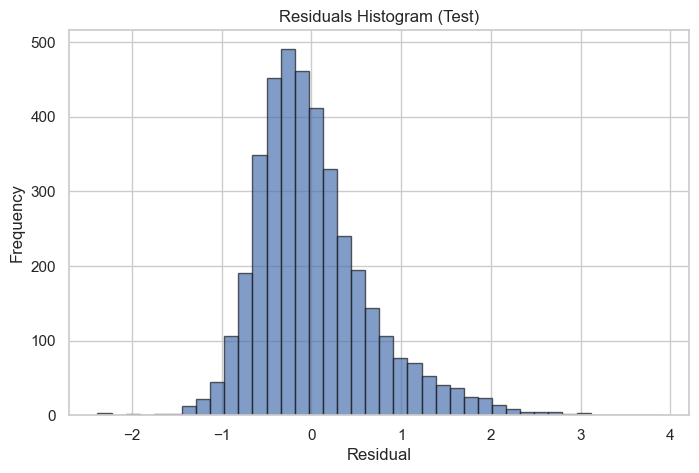

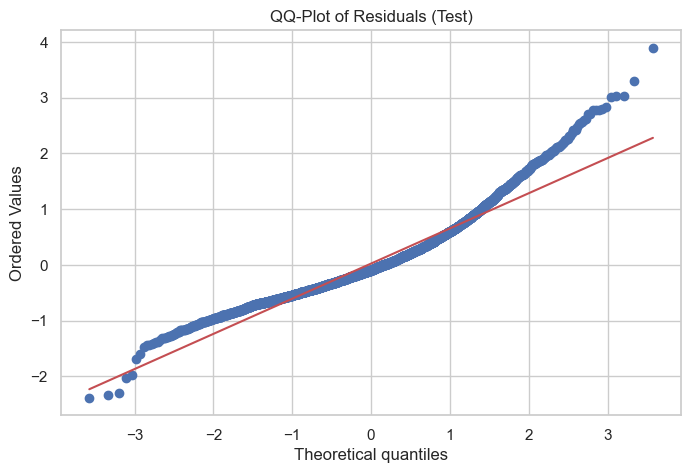

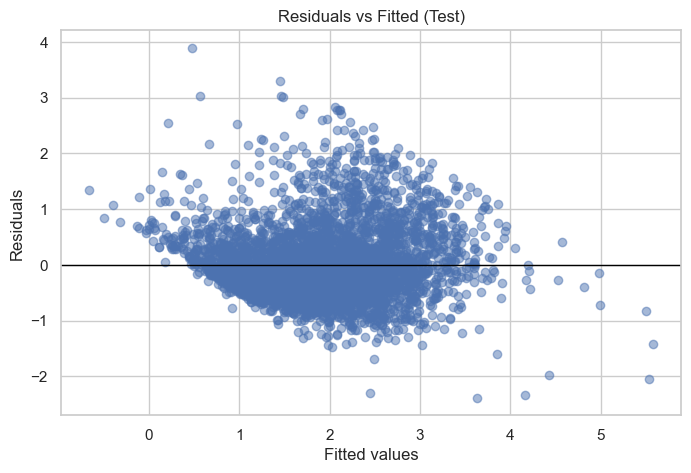

Residual summary:


count    3930.0000
mean        0.0233
std         0.6511
min        -2.3827
25%        -0.4143
50%        -0.0954
75%         0.3268
max         3.8953
dtype: float64

In [22]:
resid = y_test - y_pred_test_sk
fitted = y_pred_test_sk

# Histogram
plt.figure()
plt.hist(resid, bins=40, edgecolor="k", alpha=0.7)
plt.title("Residuals Histogram (Test)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# QQ-plot
plt.figure()
stats.probplot(resid, dist="norm", plot=plt)
plt.title("QQ-Plot of Residuals (Test)")
plt.show()

# Residual vs Fitted
plt.figure()
plt.scatter(fitted, resid, alpha=0.5)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Test)")
plt.show()

print("Residual summary:")
display(pd.Series(resid).describe())

**6. Multicollinearity Check** (*VIF* & *Correlation*)
- *VIF* (Variance Inflation Factor): values > 10 (standard 5 or 10) indicate serious multicollinearity.
- *Correlation* Heatmap

,feature,VIF
7,Longitude,651.0528
6,Latitude,564.5065
2,AveRooms,50.6969
3,AveBedrms,44.8674
0,MedInc,14.6030
1,HouseAge,7.3881
4,Population,3.1421
5,AveOccup,1.0904


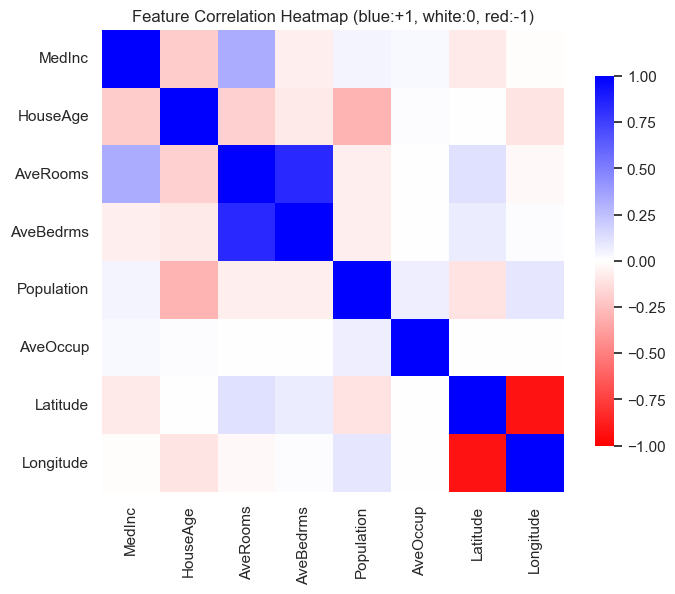

In [23]:
# VIF on unscaled training features (scale doesn't affect VIF for linear relationships)
X_train_df = pd.DataFrame(X_train, columns=feature_names)
vif_data = []
for i, col in enumerate(feature_names):
    vif = variance_inflation_factor(X_train_df.values, i)
    vif_data.append({"feature": col, "VIF": vif})
vif_df = pd.DataFrame(vif_data).sort_values("VIF", ascending=False)
display(vif_df)

# Correlation heatmap
corr = df.drop(columns=["target"]).corr()

# 'bwr' is blue=negative/red=positive; we reverse to make blue=+1 and red=-1 as requested
cmap = sns.color_palette("bwr_r", as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr, vmin=-1, vmax=1, center=0, cmap=cmap, annot=False, square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Feature Correlation Heatmap (blue:+1, white:0, red:-1)")
plt.show()

The following pairs show very high correlations:
1) `Latitude` and `Longitude`
2) `AveRooms` and `AveBedrms`
For further analysis, we drop both `Latitude` and `Longitude`, and `AveBedrms`.

**7. (Refined) Multiple Regression** (reduced model)
- Based on VIF and correlation heatmap, we can drop:
1) Latitude
2) Longitude
3) AveBedrms
- For better analysis, we use **3 predictors** (with the largest absolute correlation with the target) for the ___reduced___ model.
- Compare ___full___ vs ___reduced___ using:
1) *ANOVA (nested models)* ( H$_0$ : dropped variables add no extra explanatory power)
2) *Adjusted* $R^2$, *AIC*, *BIC* (metrics for model selection criteria).

In [24]:
# Select top 3 (based on correlation to target)

# Explicit exclusion
excluded = ["Latitude", "Longitude", "AveBedrms"]
available_features = [f for f in feature_names if f not in excluded]

# Correlation with target (only among allowed features)
corr_to_target = (
    df[available_features + ["target"]]
    .corr(numeric_only=True)["target"]
    .drop("target")
    .abs()
    .sort_values(ascending=False)
)

# Select top-3 predictors
top3 = corr_to_target.head(3).index.tolist()
print("Selected top-3 predictors (after exclusions):", top3)

# Full vs reduced using statsmodels
X_full = sm.add_constant(df[feature_names])
y_all = df["target"]

ols_full = sm.OLS(y_all, X_full).fit()

X_reduced = sm.add_constant(df[top3])
ols_reduced = sm.OLS(y_all, X_reduced).fit()

print("\nFull model summary (fit stats):")
display(ols_full.summary2().tables[0])

print("\nReduced model summary (fit stats):")
display(ols_reduced.summary2().tables[0])

# ANOVA (reduced nested within full)
anova_res = anova_lm(ols_reduced, ols_full)
print("\nANOVA Comparison (Reduced vs Full):")
display(anova_res)

comp_df = pd.DataFrame({
    "model": ["Full", "Reduced"],
    "adj_R2": [ols_full.rsquared_adj, ols_reduced.rsquared_adj],
    "AIC": [ols_full.aic, ols_reduced.aic],
    "BIC": [ols_full.bic, ols_reduced.bic],
})
display(comp_df)

print(
    "\nInterpretation guide:\n"
    "- ANOVA tests H0: dropped variables have no additional explanatory power beyond the reduced model. "
    "A small p-value => reject H0 => the dropped vars are significant.\n"
    "- Adjusted R^2 balances fit with number of predictors (penalizes complexity). Higher is better.\n"
    "- AIC/BIC are information criteria (lower is better). BIC penalizes complexity more strongly than AIC."
)


Selected top-3 predictors (after exclusions): ['MedInc', 'AveRooms', 'HouseAge']

Full model summary (fit stats):


,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.574
1,Dependent Variable:,target,AIC:,37844.4021
2,Date:,2025-08-25 15:11,BIC:,37915.3737
3,No. Observations:,19648,Log-Likelihood:,-18913.
4,Df Model:,8,F-statistic:,3312.
5,Df Residuals:,19639,Prob (F-statistic):,0.00
6,R-squared:,0.574,Scale:,0.40163



Reduced model summary (fit stats):


,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.463
1,Dependent Variable:,target,AIC:,42399.5143
2,Date:,2025-08-25 15:11,BIC:,42431.0572
3,No. Observations:,19648,Log-Likelihood:,-21196.
4,Df Model:,3,F-statistic:,5644.
5,Df Residuals:,19644,Prob (F-statistic):,0.00
6,R-squared:,0.463,Scale:,0.50655



ANOVA Comparison (Reduced vs Full):


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,19644.0,9950.7413,0.0,NaN,NaN,NaN
1,19639.0,7887.6810,5.0,2063.0603,1027.3347,0.0


,model,adj_R2,AIC,BIC
0,Full,0.5741,37844.4021,37915.3737
1,Reduced,0.4629,42399.5143,42431.0572



Interpretation guide:
- ANOVA tests H0: dropped variables have no additional explanatory power beyond the reduced model. A small p-value => reject H0 => the dropped vars are significant.
- Adjusted R^2 balances fit with number of predictors (penalizes complexity). Higher is better.
- AIC/BIC are information criteria (lower is better). BIC penalizes complexity more strongly than AIC.


**Note**: It suggests that we can't drop the variables, as they are statistically significant. However, for the sake of simplicity and continuation, we will move forward. In an actual analysis, the initial dataset needs transformations to adhere to the assumptions (many variables break the normality assumption, some are categorical, etc).

**8. Simple Linear Regression** (best single predictor)
- Fit SLR with the single predictor most correlated to the target. Usually underperforms MLR but good as a baseline.

Best single predictor: MedInc
Simple LR:
  Test R^2: 0.4107241031039385
  Test RMSE: 0.7516349508876586


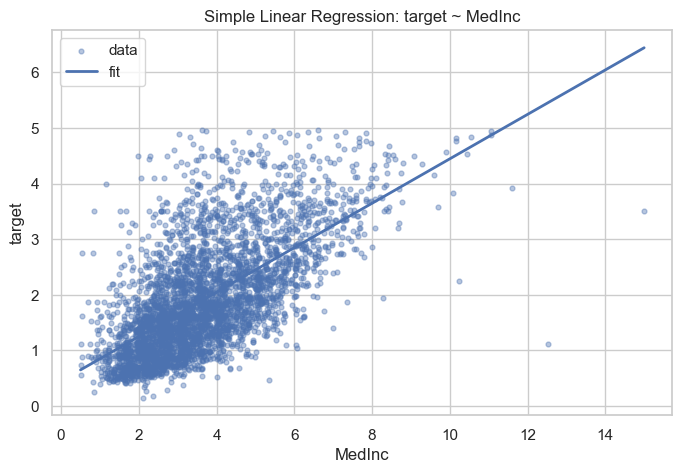

In [25]:
best_single = corr_to_target.index[0]
print("Best single predictor:", best_single)

X_single = df[[best_single]].values
y_all = df["target"].values

Xtr_s, Xte_s, ytr_s, yte_s = train_test_split(
    X_single, y_all, test_size=0.2, random_state=42
)
slr = LinearRegression().fit(Xtr_s, ytr_s)
yhat_s = slr.predict(Xte_s)

print("Simple LR:")
print("  Test R^2:", r2_score(yte_s, yhat_s))
print("  Test RMSE:", rmse_score(yte_s, yhat_s))

# Visualize fit
plt.figure()
plt.scatter(Xte_s, yte_s, alpha=0.4, s=12, label="data")
xline = np.linspace(Xte_s.min(), Xte_s.max(), 100).reshape(-1, 1)
plt.plot(xline, slr.predict(xline), linewidth=2, label="fit")
plt.xlabel(best_single)
plt.ylabel("target")
plt.title(f"Simple Linear Regression: target ~ {best_single}")
plt.legend()
plt.show()

**9. PCA + Regression**
>**Why PCA?** PCA reduces multicollinearity by transforming correlated predictors into orthogonal components.
- We'll fit PCA on standardized features, keep enough components for **90%** variance, and regress on PCs.

In [26]:
scaler_pca = StandardScaler()
X_scaled_all = scaler_pca.fit_transform(df[feature_names])

pca = PCA(n_components=0.90, svd_solver="full", random_state=42)
X_pc = pca.fit_transform(X_scaled_all)

print("Original features:", X.shape[1], "| PCA components retained:", X_pc.shape[1])
print("Explained variance ratio (first 10):", np.round(pca.explained_variance_ratio_[:10], 4))

Xtr_pc, Xte_pc, ytr_pc, yte_pc = train_test_split(X_pc, df["target"].values, test_size=0.2, random_state=86)
lr_pca = LinearRegression().fit(Xtr_pc, ytr_pc)
yhat_pc = lr_pca.predict(Xte_pc)

print("PCA Regression:")
print("  Test R^2:", r2_score(yte_pc, yhat_pc))
print("  Test RMSE:", rmse_score(yte_pc, yhat_pc))

Original features: 8 | PCA components retained: 5
Explained variance ratio (first 10): [0.2544 0.2364 0.1636 0.1258 0.1231]
PCA Regression:
  Test R^2: 0.3617950325607515
  Test RMSE: 0.7899452240501981


**10. Bonus: Beyond Regression (_Clustering_ & _Classification_)**
- *Clustering* (unsupervised): KMeans on standardized features - exploratory structure.
- *Classification* (supervised): Binarize target at its median (high vs low) > logistic regression, with metrics.


KMeans silhouette score (higher is better): 0.29616241982269237


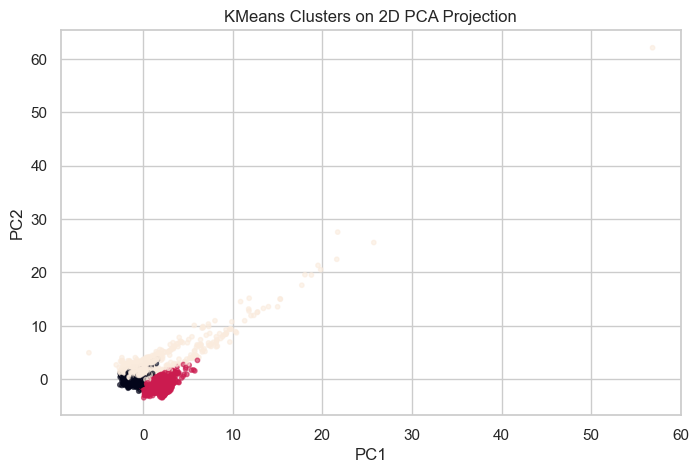

Classification Report (High vs Low price):
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       971
           1       0.82      0.84      0.83       994

    accuracy                           0.83      1965
   macro avg       0.83      0.83      0.83      1965
weighted avg       0.83      0.83      0.83      1965

Confusion Matrix:
[[792 179]
 [160 834]]


In [27]:
# --- Clustering (KMeans) ---
scaler_km = StandardScaler()
X_std = scaler_km.fit_transform(df[feature_names])

kmeans = KMeans(n_clusters=3, n_init="auto", random_state=86)
labels = kmeans.fit_predict(X_std)

sil = silhouette_score(X_std, labels)
print("KMeans silhouette score (higher is better):", sil)

# Quick 2D PCA projection for visualization
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_std)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=10, alpha=0.6)
plt.title("KMeans Clusters on 2D PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# --- Classification (Logistic Regression) ---
median_target = df["target"].median()
y_bin = (df["target"] >= median_target).astype(int)  # 1=high, 0=low

Xtr_c, Xte_c, ytr_c, yte_c = train_test_split(X_std, y_bin, test_size=0.1, random_state=86)

clf = LogisticRegression(max_iter=1000).fit(Xtr_c, ytr_c)
y_pred_c = clf.predict(Xte_c)

print("Classification Report (High vs Low price):")
print(classification_report(yte_c, y_pred_c))
print("Confusion Matrix:")
print(confusion_matrix(yte_c, y_pred_c))